In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import IPython
import pywt

From the SNR formula, if we want noise of a certain snr, we have the amplitude of noise :

$$ \sigma_n^2 = \frac{\sigma_x^2}{10^{\frac{iSNR}{20}}}  \left\{ \begin{array}{l}
                                                                        \sigma_n & linear & iSNR \\
                                                                        \sigma_x & the & amplitude & of & signal \\
                                                                        iSNR & in & dB
                                                                  \end{array}
                                                          \right.$$

In [2]:
def SNR(x,n):
    quotient = np.std(x) / np.std(n-x)
    return 20 * np.log10(quotient)

def generate_noise(x, dB):
    sigma_n = np.std(x)/(10**(dB/20))
    noise = np.random.normal(0,sigma_n, x.shape)
    res = x + noise
    return noise/np.max(noise), res/np.max(res)

(442, 448)

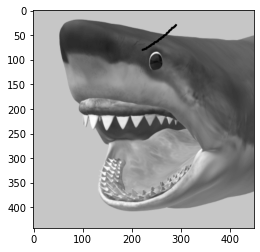

In [3]:
img = cv2.imread("angry_shark.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img/255
img = img[1:, :]  #cutting one row pixel to have even-number of rows
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
img.shape

In [4]:
n0, n0_img = generate_noise(img, 0)
n10, n10_img = generate_noise(img, 10)
n20, n20_img = generate_noise(img, 20)

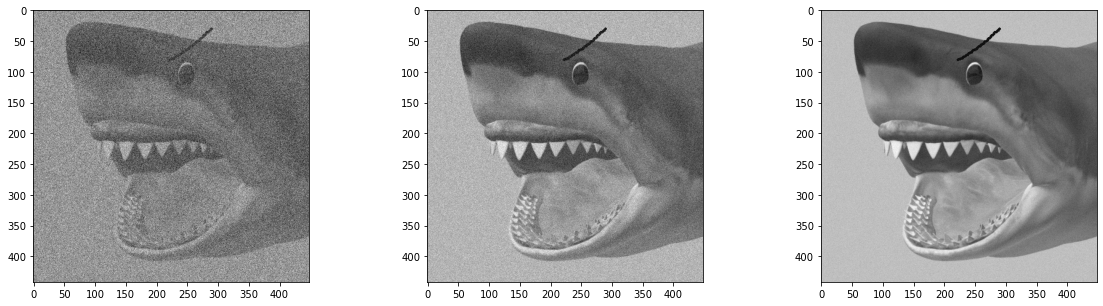

In [5]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].imshow(n0_img, cmap='gray')
ax[1].imshow(n10_img, cmap='gray')
ax[2].imshow(n20_img, cmap='gray')

Applying dwt on our noised images

In [6]:
n0_imgA, n0_imgD = pywt.dwt2(n0_img, 'bior1.3', 'per')
n10_imgA, n10_imgD = pywt.dwt2(n10_img, 'bior1.3', 'per')
n20_imgA, n20_imgD = pywt.dwt2(n20_img, 'bior1.3', 'per')

These are the low pass filtered images

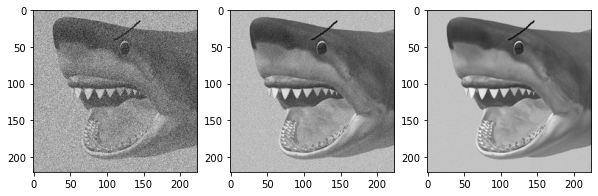

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].imshow(n0_imgA, cmap='gray')
ax[1].imshow(n10_imgA, cmap='gray')
ax[2].imshow(n20_imgA, cmap='gray')

The high-passed filtered for n20

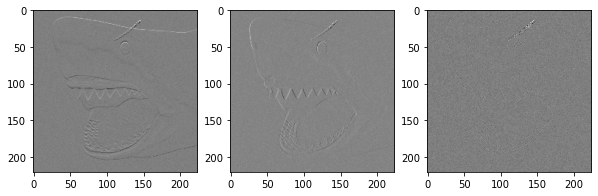

In [8]:
n20H, n20V, n20D = n20_imgD
fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].imshow(n20H, cmap='gray')
ax[1].imshow(n20V, cmap='gray')
ax[2].imshow(n20D, cmap='gray')

We apply a soft and hard thresholding on the images

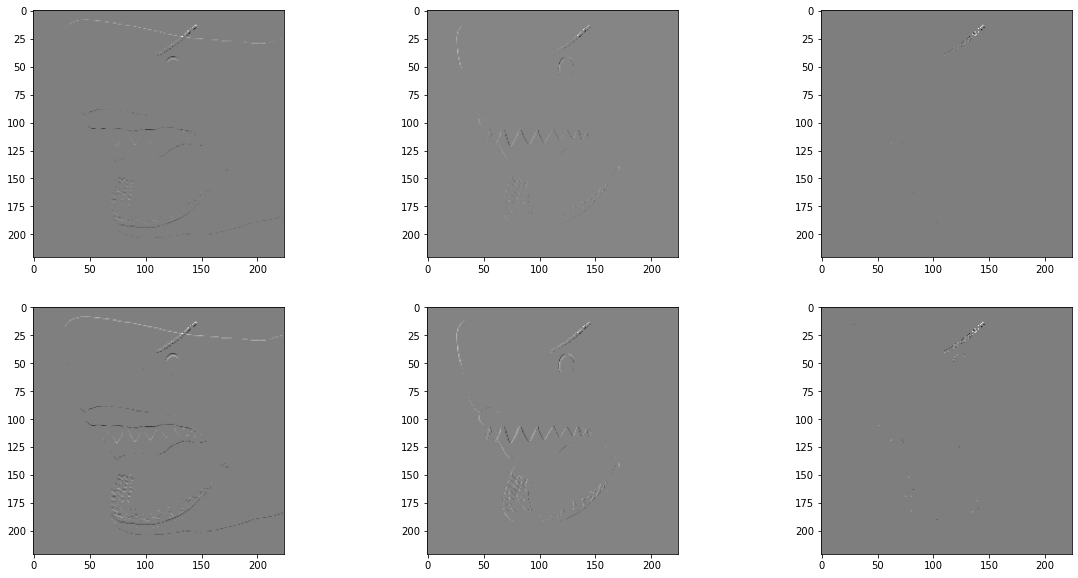

In [9]:
th_value = 0.1

n20_softH = pywt.threshold(n20H, value=th_value, mode='soft')
n20_softV = pywt.threshold(n20V, value=th_value, mode='soft')
n20_softD = pywt.threshold(n20D, value=th_value, mode='soft')

n20_hardH = pywt.threshold(n20H, value=th_value, mode='hard')
n20_hardV = pywt.threshold(n20V, value=th_value, mode='hard')
n20_hardD = pywt.threshold(n20D, value=th_value, mode='hard')

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0][0].imshow(n20_softH, cmap="gray")
ax[0][1].imshow(n20_softV, cmap="gray")
ax[0][2].imshow(n20_softD, cmap="gray")
ax[1][0].imshow(n20_hardH, cmap="gray")
ax[1][1].imshow(n20_hardV, cmap="gray")
ax[1][2].imshow(n20_hardD, cmap="gray")

In [10]:
n0H, n0V, n0D = n0_imgD
th_value = 0.7

n0_softH = pywt.threshold(n0H, value=th_value, mode='soft')
n0_softV = pywt.threshold(n0V, value=th_value, mode='soft')
n0_softD = pywt.threshold(n0D, value=th_value, mode='soft')

n0_hardH = pywt.threshold(n0H, value=th_value, mode='hard')
n0_hardV = pywt.threshold(n0V, value=th_value, mode='hard')
n0_hardD = pywt.threshold(n0D, value=th_value, mode='hard')

reconstruct image

Text(0.5, 1.0, 'recovered')

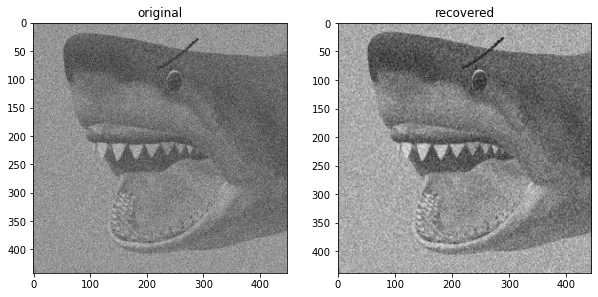

In [11]:
coeffs = (n0_imgA, (n0_softH, n0_softV, n0_softD))
rec_img = pywt.idwt2(coeffs, 'bior1.3')

fig, ax  = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(n0_img, cmap="gray")
ax[0].set_title('original')
ax[1].imshow(rec_img, cmap="gray")
ax[1].set_title('recovered')

We see very little difference since we only applied the filters once

In [12]:
def denoise_wt(img, th, lvl):
    coeffs = pywt.wavedec2(img, 'bior1.3', level=lvl)
    for i in range(1, len(coeffs)):
        h, v, d = coeffs[i]
        h = pywt.threshold(h, value=th, mode="soft")
        v = pywt.threshold(v, value=th, mode="soft")
        d = pywt.threshold(d, value=th, mode="soft")
        coeffs[i] = (h, v, d)
    return pywt.waverec2(coeffs, 'bior1.3')


D:\Anaconda\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 7 is too high: all coefficients will experience boundary effects.
  warnings.warn(


(442, 448)

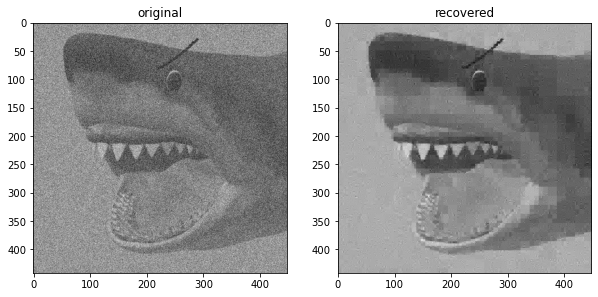

In [13]:
th=0.2
rec_img = denoise_wt(n0_img, th, 7)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(n0_img, cmap="gray")
ax[0].set_title("original")
ax[1].imshow(rec_img, cmap="gray")
ax[1].set_title("recovered")
rec_img.shape

D:\Anaconda\lib\site-packages\pywt\_thresholding.py:23: RuntimeWarning: invalid value encountered in true_divide
  thresholded = (1 - value/magnitude)


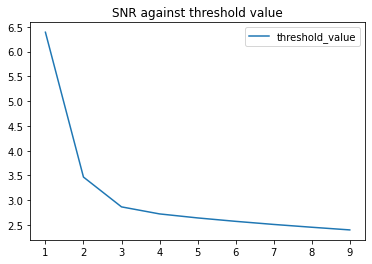

In [14]:
th = np.linspace(0, 1, 10)
y = np.zeros(len(th))

fig, ax = plt.subplots()
for i, v in enumerate(th):
    rec = denoise_wt(n0_img, v, 7)
    y[i] = SNR(n0_img, rec)
ax.plot(np.arange(len(th)), y, label="threshold_value")
ax.set_title('SNR against threshold value')
ax.legend()

### Invariant to translation wavelet transform

In [15]:
def translation_invariant_wt(img, m, th_value):
    res = np.zeros((img.shape[0], img.shape[1]))
    #construct the translation operator
    tDim = m*m
    [dY,dX] = np.meshgrid(np.arange(0,m),np.arange(0,m))
    delta = np.concatenate( (dX.reshape(tDim,1), dY.reshape(tDim,1)), axis=1)
    #average translations
    for i in range(tDim):
        shifted = np.roll(img, delta[i,:])
        d_shift = denoise_wt(shifted,th_value, 5)
        shifted = np.roll(d_shift, -delta[i, :])
        res =  (1 - i/tDim)*res + i/tDim*shifted
    return res

In [16]:
wt = translation_invariant_wt(n0_img, 4, 0.5)

Text(0.5, 1.0, 'recovered')

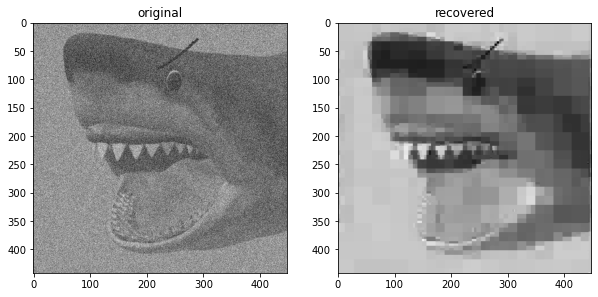

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(n0_img, cmap="gray")
ax[0].set_title("original")
ax[1].imshow(wt, cmap="gray")
ax[1].set_title("recovered")